# JupyterLite で学ぶ scipy.stats 中級チュートリアル

このノートブックは、**JupyterLite（ブラウザだけで動く Jupyter 環境）** 上で、
scipy.stats の中級レベルの機能を学ぶためのチュートリアルです。

## 対象者
- scipy.stats の基礎（確率分布、基本統計量）を理解している方
- 統計的仮説検定や相関分析を学びたい方

## このチュートリアルで学ぶこと
1. t検定（1標本、対応のある2標本、独立2標本）
2. 分散の検定とF検定
3. カイ二乗検定（適合度検定、独立性検定）
4. 相関分析（ピアソン、スピアマン、ケンドール）
5. ノンパラメトリック検定
6. 分散分析（ANOVA）
7. 信頼区間の計算
8. 多重比較補正

## 0. 環境準備（JupyterLite 用）

まず、必要なライブラリをインストールします。

In [1]:
try:
    import piplite
    await piplite.install(["numpy", "pandas", "matplotlib", "scipy", "seaborn", "japanize-matplotlib-jlite"])
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import japanize_matplotlib_jlite

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)

# 警告の抑制
import warnings
warnings.filterwarnings('ignore')

print("準備完了")

準備完了


---
## 1. t検定

**t検定** は、平均値に関する仮説を検定する手法です。
母分散が未知の場合に使用します。

### 1.1 1標本t検定（One-sample t-test）

**目的**: 標本平均が特定の値（母平均）と等しいかを検定

**帰無仮説 H₀**: μ = μ₀（母平均は指定した値に等しい）

**対立仮説 H₁**: μ ≠ μ₀（両側検定の場合）

In [3]:
# サンプルデータ: あるクラスのテスト点数
np.random.seed(42)
scores = stats.norm.rvs(loc=72, scale=12, size=30)  # 実際の平均は72点

# 「母平均は70点である」という仮説を検定
t_stat, p_value = stats.ttest_1samp(scores, popmean=70)

print("=== 1標本t検定 ===")
print(f"帰無仮説: 母平均 = 70")
print(f"標本平均: {scores.mean():.2f}")
print(f"標本標準偏差: {scores.std(ddof=1):.2f}")
print(f"t統計量: {t_stat:.4f}")
print(f"p値（両側）: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却' if p_value < 0.05 else '帰無仮説を棄却しない'}")

=== 1標本t検定 ===
帰無仮説: 母平均 = 70
標本平均: 69.74
標本標準偏差: 10.80
t統計量: -0.1307
p値（両側）: 0.8969

結論（α=0.05）: 帰無仮説を棄却しない


### 1.2 対応のある2標本t検定（Paired t-test）

**目的**: 同じ被験者の前後比較など、対応のあるデータの平均差を検定

**帰無仮説 H₀**: μd = 0（差の平均は0）

In [4]:
# サンプルデータ: 同じ生徒の訓練前後のテスト点数
np.random.seed(42)
n = 25
before = stats.norm.rvs(loc=65, scale=10, size=n)
after = before + stats.norm.rvs(loc=5, scale=3, size=n)  # 平均5点向上

# 対応のあるt検定
t_stat, p_value = stats.ttest_rel(after, before)

print("=== 対応のある2標本t検定 ===")
print(f"帰無仮説: 訓練前後で差がない")
print(f"訓練前の平均: {before.mean():.2f}")
print(f"訓練後の平均: {after.mean():.2f}")
print(f"平均差: {(after - before).mean():.2f}")
print(f"t統計量: {t_stat:.4f}")
print(f"p値（両側）: {p_value:.6f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（訓練効果あり）' if p_value < 0.05 else '帰無仮説を棄却しない'}")

=== 対応のある2標本t検定 ===
帰無仮説: 訓練前後で差がない
訓練前の平均: 63.36
訓練後の平均: 67.50
平均差: 4.14
t統計量: 7.4501
p値（両側）: 0.000000

結論（α=0.05）: 帰無仮説を棄却（訓練効果あり）


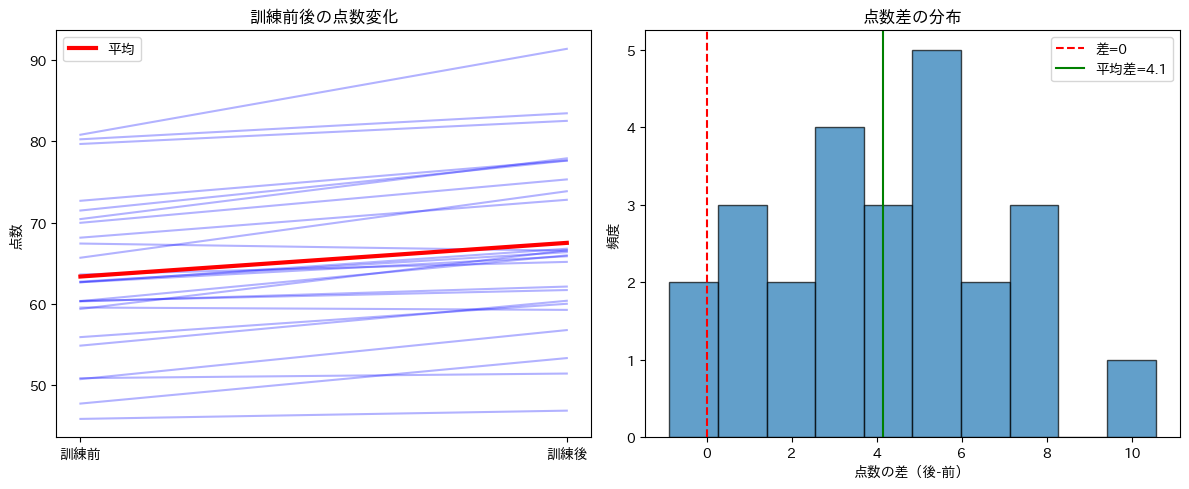

In [5]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 前後の比較
for i in range(n):
    axes[0].plot([0, 1], [before[i], after[i]], 'b-', alpha=0.3)
axes[0].plot([0, 1], [before.mean(), after.mean()], 'r-', linewidth=3, label='平均')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['訓練前', '訓練後'])
axes[0].set_ylabel('点数')
axes[0].set_title('訓練前後の点数変化')
axes[0].legend()

# 差の分布
diff = after - before
axes[1].hist(diff, bins=10, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', label='差=0')
axes[1].axvline(x=diff.mean(), color='g', linestyle='-', label=f'平均差={diff.mean():.1f}')
axes[1].set_xlabel('点数の差（後-前）')
axes[1].set_ylabel('頻度')
axes[1].set_title('点数差の分布')
axes[1].legend()

plt.tight_layout()
plt.show()

### 1.3 独立2標本t検定（Independent t-test）

**目的**: 2つの独立したグループの平均値の差を検定

**帰無仮説 H₀**: μ₁ = μ₂（2群の平均は等しい）

In [6]:
# サンプルデータ: 2つのクラスのテスト点数
np.random.seed(42)
class_a = stats.norm.rvs(loc=70, scale=10, size=30)
class_b = stats.norm.rvs(loc=75, scale=12, size=35)

# 独立2標本t検定（等分散を仮定）
t_stat, p_value = stats.ttest_ind(class_a, class_b)

print("=== 独立2標本t検定 ===")
print(f"帰無仮説: 2クラスの平均点は等しい")
print(f"クラスAの平均: {class_a.mean():.2f} (n={len(class_a)})")
print(f"クラスBの平均: {class_b.mean():.2f} (n={len(class_b)})")
print(f"t統計量: {t_stat:.4f}")
print(f"p値（両側）: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（差あり）' if p_value < 0.05 else '帰無仮説を棄却しない'}")

=== 独立2標本t検定 ===
帰無仮説: 2クラスの平均点は等しい
クラスAの平均: 68.12 (n=30)
クラスBの平均: 73.01 (n=35)
t統計量: -1.9510
p値（両側）: 0.0555

結論（α=0.05）: 帰無仮説を棄却しない


### 1.4 Welchのt検定（等分散を仮定しない）

In [7]:
# Welchのt検定（分散が異なる場合に推奨）
t_stat_welch, p_value_welch = stats.ttest_ind(class_a, class_b, equal_var=False)

print("=== Welchのt検定（等分散を仮定しない）===")
print(f"t統計量: {t_stat_welch:.4f}")
print(f"p値（両側）: {p_value_welch:.4f}")
print(f"\n※ 分散が異なる可能性がある場合はWelchのt検定を使用")

=== Welchのt検定（等分散を仮定しない）===
t統計量: -1.9804
p値（両側）: 0.0520

※ 分散が異なる可能性がある場合はWelchのt検定を使用


### 1.5 片側検定

In [8]:
# 片側検定: クラスBの方が高いか？
t_stat, p_value_two = stats.ttest_ind(class_a, class_b)

# 片側p値の計算
if t_stat < 0:  # class_a < class_b の方向
    p_value_one = p_value_two / 2
else:
    p_value_one = 1 - p_value_two / 2

print("=== 片側検定 ===")
print(f"帰無仮説: μA ≥ μB")
print(f"対立仮説: μA < μB（クラスBの方が高い）")
print(f"p値（片側）: {p_value_one:.4f}")

=== 片側検定 ===
帰無仮説: μA ≥ μB
対立仮説: μA < μB（クラスBの方が高い）
p値（片側）: 0.0278


### 📝 1章 練習問題

1. 100点満点のテストで、ある製品の合格点が75点とする。30人の受験者の点数データを生成し、平均が75点と異なるかを1標本t検定で検定しなさい。
2. 新しいダイエット法の効果を検証するため、10人の被験者の開始時と1ヶ月後の体重データを生成し、対応のあるt検定を行いなさい。
3. 独立2標本t検定とWelchのt検定の違いを説明しなさい。

In [9]:
# 練習問題の解答欄



---
## 2. 分散の検定とF検定

分散に関する仮説を検定する方法を学びます。

### 2.1 ルビーン検定（等分散性の検定）

In [10]:
# 2群の分散が等しいかを検定
np.random.seed(42)
group1 = stats.norm.rvs(loc=50, scale=10, size=30)
group2 = stats.norm.rvs(loc=50, scale=15, size=30)  # 分散が異なる

# ルビーン検定
stat, p_value = stats.levene(group1, group2)

print("=== ルビーン検定（等分散性の検定）===")
print(f"帰無仮説: 2群の分散は等しい")
print(f"グループ1の分散: {group1.var(ddof=1):.2f}")
print(f"グループ2の分散: {group2.var(ddof=1):.2f}")
print(f"検定統計量: {stat:.4f}")
print(f"p値: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'等分散でない' if p_value < 0.05 else '等分散と仮定できる'}")

=== ルビーン検定（等分散性の検定）===
帰無仮説: 2群の分散は等しい
グループ1の分散: 81.00
グループ2の分散: 195.06
検定統計量: 6.4999
p値: 0.0135

結論（α=0.05）: 等分散でない


### 2.2 バートレット検定

In [11]:
# バートレット検定（正規性を仮定）
stat, p_value = stats.bartlett(group1, group2)

print("=== バートレット検定 ===")
print(f"検定統計量: {stat:.4f}")
print(f"p値: {p_value:.4f}")
print("\n※ バートレット検定は正規性に敏感。正規分布でない場合はルビーン検定を推奨")

=== バートレット検定 ===
検定統計量: 5.3365
p値: 0.0209

※ バートレット検定は正規性に敏感。正規分布でない場合はルビーン検定を推奨


### 2.3 F検定（2群の分散比の検定）

In [12]:
# F検定を手動で計算
def f_test(x, y):
    """2群の分散比のF検定"""
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    
    # 大きい方を分子に
    if var_x >= var_y:
        f_stat = var_x / var_y
        df1, df2 = len(x) - 1, len(y) - 1
    else:
        f_stat = var_y / var_x
        df1, df2 = len(y) - 1, len(x) - 1
    
    # 両側p値
    p_value = 2 * min(stats.f.cdf(f_stat, df1, df2), 
                      1 - stats.f.cdf(f_stat, df1, df2))
    
    return f_stat, p_value, df1, df2

f_stat, p_value, df1, df2 = f_test(group1, group2)

print("=== F検定 ===")
print(f"F統計量: {f_stat:.4f}")
print(f"自由度: ({df1}, {df2})")
print(f"p値: {p_value:.4f}")

=== F検定 ===
F統計量: 2.4082
自由度: (29, 29)
p値: 0.0209


### 📝 2章 練習問題

1. 3つのグループのデータを生成し、ルビーン検定で等分散性を検定しなさい。
2. 等分散性の検定結果に基づいて、適切なt検定（Studentのt検定またはWelchのt検定）を選択しなさい。

In [13]:
# 練習問題の解答欄



---
## 3. カイ二乗検定

カテゴリカルデータに対する検定を学びます。

### 3.1 適合度検定（Goodness of fit test）

**目的**: 観測度数が期待度数と一致するかを検定

**例**: サイコロが公平かどうか

In [14]:
# サイコロを120回振った結果
observed = np.array([18, 23, 16, 21, 22, 20])  # 各目の出た回数
expected = np.array([20, 20, 20, 20, 20, 20])  # 期待値（公平なら各20回）

# カイ二乗適合度検定
chi2_stat, p_value = stats.chisquare(observed, f_exp=expected)

print("=== カイ二乗適合度検定 ===")
print(f"帰無仮説: サイコロは公平である")
print(f"\n観測度数: {observed}")
print(f"期待度数: {expected}")
print(f"\nχ²統計量: {chi2_stat:.4f}")
print(f"p値: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（公平でない）' if p_value < 0.05 else '帰無仮説を棄却しない（公平と考えられる）'}")

=== カイ二乗適合度検定 ===
帰無仮説: サイコロは公平である

観測度数: [18 23 16 21 22 20]
期待度数: [20 20 20 20 20 20]

χ²統計量: 1.7000
p値: 0.8889

結論（α=0.05）: 帰無仮説を棄却しない（公平と考えられる）


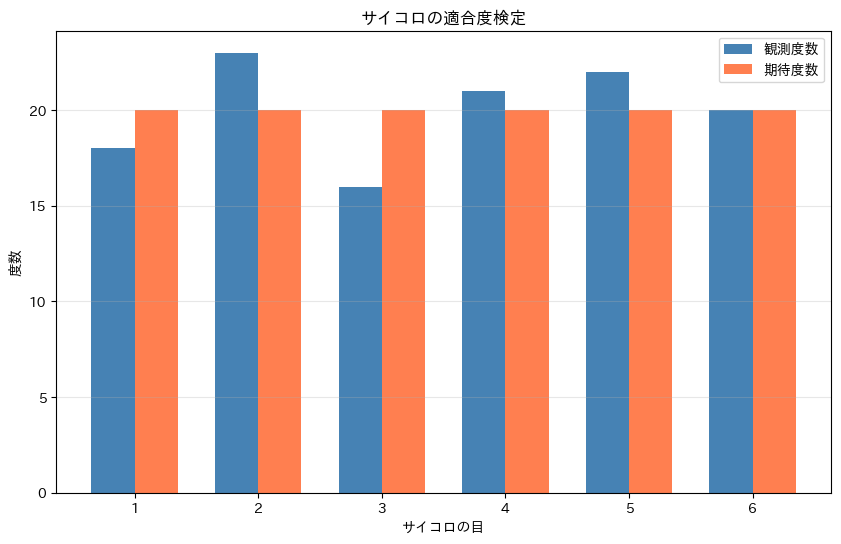

In [15]:
# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, 7)
width = 0.35

ax.bar(x - width/2, observed, width, label='観測度数', color='steelblue')
ax.bar(x + width/2, expected, width, label='期待度数', color='coral')

ax.set_xlabel('サイコロの目')
ax.set_ylabel('度数')
ax.set_title('サイコロの適合度検定')
ax.set_xticks(x)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.show()

### 3.2 独立性検定（Test of independence）

**目的**: 2つのカテゴリカル変数が独立かどうかを検定

**例**: 性別と製品の好みに関連があるか

In [16]:
# 分割表（クロス集計表）
# 行: 性別（男性、女性）
# 列: 製品の好み（A, B, C）
contingency_table = np.array([
    [30, 20, 50],   # 男性
    [20, 40, 40]    # 女性
])

# カイ二乗独立性検定
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("=== カイ二乗独立性検定 ===")
print(f"帰無仮説: 性別と製品の好みは独立である")
print(f"\n観測度数:")
print(pd.DataFrame(contingency_table, 
                   index=['男性', '女性'], 
                   columns=['製品A', '製品B', '製品C']))
print(f"\n期待度数:")
print(pd.DataFrame(expected.round(1), 
                   index=['男性', '女性'], 
                   columns=['製品A', '製品B', '製品C']))
print(f"\nχ²統計量: {chi2_stat:.4f}")
print(f"自由度: {dof}")
print(f"p値: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（関連あり）' if p_value < 0.05 else '帰無仮説を棄却しない（独立）'}")

=== カイ二乗独立性検定 ===
帰無仮説: 性別と製品の好みは独立である

観測度数:
    製品A  製品B  製品C
男性   30   20   50
女性   20   40   40

期待度数:
     製品A   製品B   製品C
男性  25.0  30.0  45.0
女性  25.0  30.0  45.0

χ²統計量: 9.7778
自由度: 2
p値: 0.0075

結論（α=0.05）: 帰無仮説を棄却（関連あり）


### 3.3 フィッシャーの正確検定

サンプルサイズが小さい場合（期待度数が5未満のセルがある場合）に使用。

In [17]:
# 2x2分割表
table_2x2 = np.array([
    [8, 2],
    [1, 9]
])

# フィッシャーの正確検定
odds_ratio, p_value = stats.fisher_exact(table_2x2)

print("=== フィッシャーの正確検定 ===")
print(f"分割表:")
print(pd.DataFrame(table_2x2, 
                   index=['条件1', '条件2'], 
                   columns=['成功', '失敗']))
print(f"\nオッズ比: {odds_ratio:.4f}")
print(f"p値: {p_value:.4f}")

=== フィッシャーの正確検定 ===
分割表:
     成功  失敗
条件1   8   2
条件2   1   9

オッズ比: 36.0000
p値: 0.0055


### 📝 3章 練習問題

1. コインを100回投げて表が55回、裏が45回出た。このコインは公平かをカイ二乗検定で調べなさい。
2. 年齢層（若年・中年・高齢）と運動習慣（する・しない）のクロス集計表を作成し、独立性を検定しなさい。
3. カイ二乗検定とフィッシャーの正確検定の使い分けを説明しなさい。

In [18]:
# 練習問題の解答欄



---
## 4. 相関分析

2つの変数間の関係の強さを測定する方法を学びます。

### 4.1 ピアソンの相関係数

線形関係の強さを測定。-1〜1の値を取る。

In [19]:
# サンプルデータ: 勉強時間と成績
np.random.seed(42)
n = 50
study_hours = np.random.uniform(1, 10, n)
scores = 40 + 5 * study_hours + np.random.normal(0, 5, n)

# ピアソンの相関係数
r, p_value = stats.pearsonr(study_hours, scores)

print("=== ピアソンの相関係数 ===")
print(f"相関係数 r: {r:.4f}")
print(f"p値: {p_value:.6f}")
print(f"\n相関の強さ: ", end='')
if abs(r) >= 0.7:
    print("強い相関")
elif abs(r) >= 0.4:
    print("中程度の相関")
elif abs(r) >= 0.2:
    print("弱い相関")
else:
    print("ほとんど相関なし")

=== ピアソンの相関係数 ===
相関係数 r: 0.9404
p値: 0.000000

相関の強さ: 強い相関


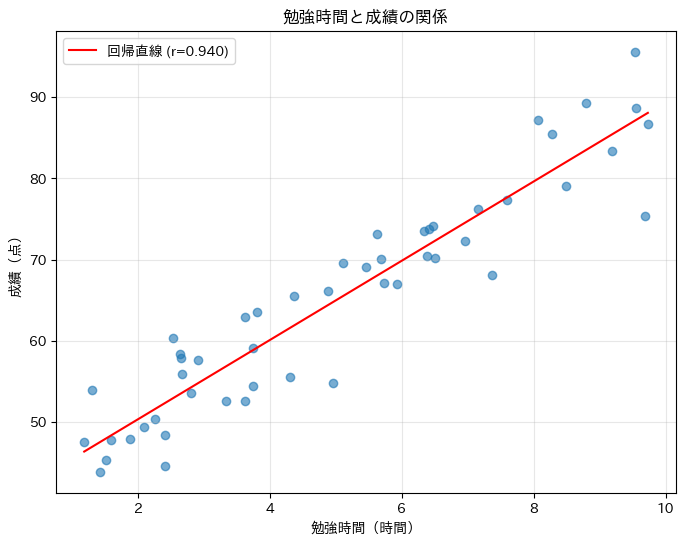

In [20]:
# 可視化
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(study_hours, scores, alpha=0.6)

# 回帰直線
z = np.polyfit(study_hours, scores, 1)
p = np.poly1d(z)
x_line = np.linspace(study_hours.min(), study_hours.max(), 100)
ax.plot(x_line, p(x_line), 'r-', label=f'回帰直線 (r={r:.3f})')

ax.set_xlabel('勉強時間（時間）')
ax.set_ylabel('成績（点）')
ax.set_title('勉強時間と成績の関係')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### 4.2 スピアマンの順位相関係数

単調関係（必ずしも線形でない）の強さを測定。外れ値に強い。

In [21]:
# 非線形だが単調な関係
np.random.seed(42)
x = np.random.uniform(0, 10, 30)
y = np.exp(x/3) + np.random.normal(0, 2, 30)

# ピアソンとスピアマンの比較
r_pearson, p_pearson = stats.pearsonr(x, y)
r_spearman, p_spearman = stats.spearmanr(x, y)

print("=== 相関係数の比較 ===")
print(f"ピアソン: r={r_pearson:.4f}, p={p_pearson:.6f}")
print(f"スピアマン: ρ={r_spearman:.4f}, p={p_spearman:.6f}")
print("\n※ 非線形な単調関係ではスピアマンの方が適切")

=== 相関係数の比較 ===
ピアソン: r=0.8651, p=0.000000
スピアマン: ρ=0.7789, p=0.000000

※ 非線形な単調関係ではスピアマンの方が適切


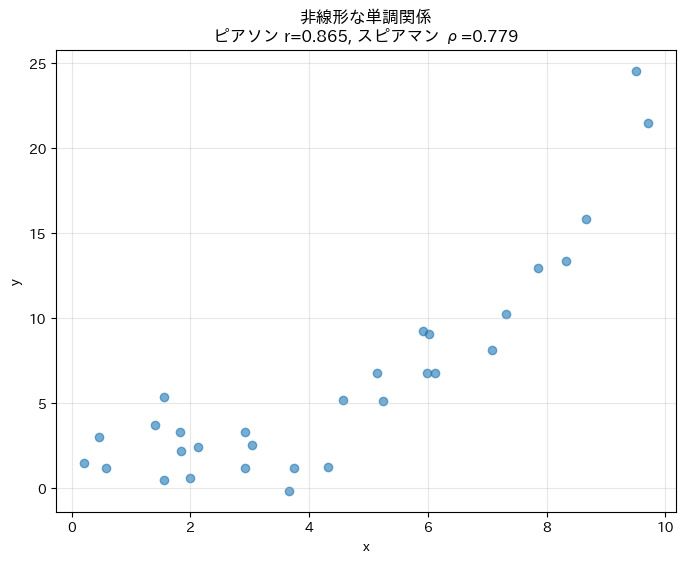

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, alpha=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'非線形な単調関係\nピアソン r={r_pearson:.3f}, スピアマン ρ={r_spearman:.3f}')
ax.grid(alpha=0.3)
plt.show()

### 4.3 ケンドールの順位相関係数

In [23]:
# ケンドールのτ
tau, p_kendall = stats.kendalltau(x, y)

print("=== ケンドールの順位相関係数 ===")
print(f"τ: {tau:.4f}")
print(f"p値: {p_kendall:.6f}")
print("\n※ ケンドールのτはスピアマンより保守的（値が小さくなりやすい）")

=== ケンドールの順位相関係数 ===
τ: 0.6092
p値: 0.000000

※ ケンドールのτはスピアマンより保守的（値が小さくなりやすい）


### 4.4 相関係数の比較

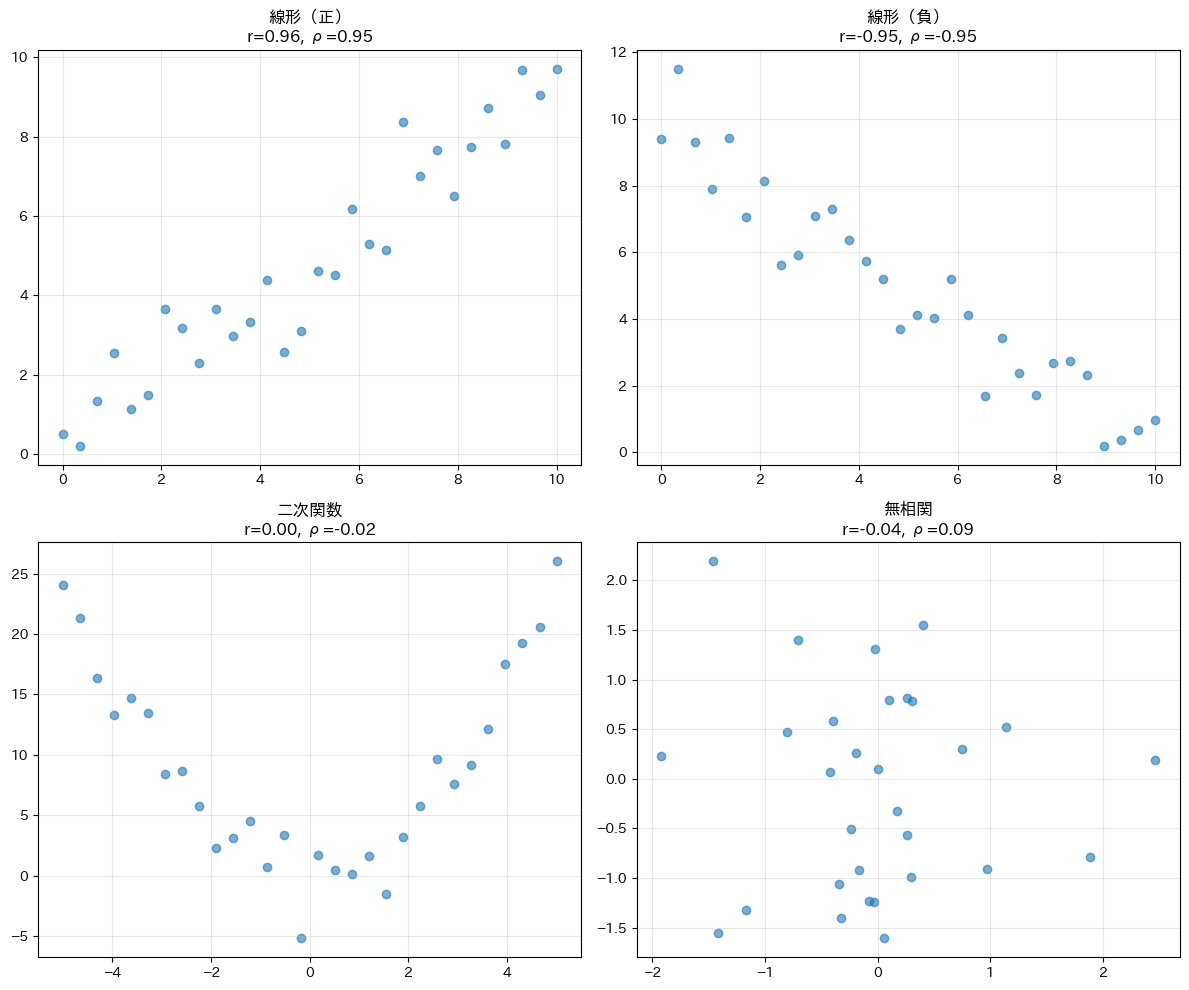

In [24]:
# 様々なケースでの相関係数
np.random.seed(42)

# 4つのケース
cases = {
    '線形（正）': (np.linspace(0, 10, 30), np.linspace(0, 10, 30) + np.random.normal(0, 1, 30)),
    '線形（負）': (np.linspace(0, 10, 30), 10 - np.linspace(0, 10, 30) + np.random.normal(0, 1, 30)),
    '二次関数': (np.linspace(-5, 5, 30), np.linspace(-5, 5, 30)**2 + np.random.normal(0, 2, 30)),
    '無相関': (np.random.randn(30), np.random.randn(30))
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, (x, y)) in zip(axes.flat, cases.items()):
    ax.scatter(x, y, alpha=0.6)
    r, _ = stats.pearsonr(x, y)
    rho, _ = stats.spearmanr(x, y)
    ax.set_title(f'{name}\nr={r:.2f}, ρ={rho:.2f}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 📝 4章 練習問題

1. 身長と体重のデータを生成し、ピアソンの相関係数を計算しなさい。
2. 外れ値を含むデータでピアソンとスピアマンの相関係数を比較し、違いを確認しなさい。
3. 相関係数が高くても因果関係があるとは限らない理由を説明しなさい。

In [25]:
# 練習問題の解答欄



---
## 5. ノンパラメトリック検定

正規性を仮定しない検定方法を学びます。

### 5.1 マン・ホイットニーのU検定

独立2群の中央値の差を検定。独立2標本t検定のノンパラメトリック版。

In [26]:
# 非正規データ（指数分布）
np.random.seed(42)
group1 = stats.expon.rvs(scale=5, size=30)
group2 = stats.expon.rvs(scale=8, size=30)

# マン・ホイットニーのU検定
u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

print("=== マン・ホイットニーのU検定 ===")
print(f"帰無仮説: 2群の分布は同じ")
print(f"\nグループ1の中央値: {np.median(group1):.2f}")
print(f"グループ2の中央値: {np.median(group2):.2f}")
print(f"\nU統計量: {u_stat:.2f}")
print(f"p値: {p_value:.4f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（差あり）' if p_value < 0.05 else '帰無仮説を棄却しない'}")

=== マン・ホイットニーのU検定 ===
帰無仮説: 2群の分布は同じ

グループ1の中央値: 2.59
グループ2の中央値: 5.67

U統計量: 320.00
p値: 0.0555

結論（α=0.05）: 帰無仮説を棄却しない


### 5.2 ウィルコクソンの符号順位検定

対応のあるデータの検定。対応のあるt検定のノンパラメトリック版。

In [27]:
# 対応のあるデータ
np.random.seed(42)
before = stats.expon.rvs(scale=10, size=25)
after = before * 0.8 + stats.norm.rvs(0, 2, size=25)  # 減少傾向

# ウィルコクソンの符号順位検定
stat, p_value = stats.wilcoxon(before, after)

print("=== ウィルコクソンの符号順位検定 ===")
print(f"帰無仮説: 前後で差がない")
print(f"\n前の中央値: {np.median(before):.2f}")
print(f"後の中央値: {np.median(after):.2f}")
print(f"\nW統計量: {stat:.2f}")
print(f"p値: {p_value:.4f}")

=== ウィルコクソンの符号順位検定 ===
帰無仮説: 前後で差がない

前の中央値: 4.69
後の中央値: 5.14

W統計量: 74.00
p値: 0.0160


### 5.3 クラスカル・ウォリス検定

3群以上の比較。一元配置分散分析のノンパラメトリック版。

In [28]:
# 3群のデータ
np.random.seed(42)
group_a = stats.expon.rvs(scale=5, size=25)
group_b = stats.expon.rvs(scale=7, size=25)
group_c = stats.expon.rvs(scale=10, size=25)

# クラスカル・ウォリス検定
stat, p_value = stats.kruskal(group_a, group_b, group_c)

print("=== クラスカル・ウォリス検定 ===")
print(f"帰無仮説: 3群の分布は同じ")
print(f"\n各群の中央値:")
print(f"  グループA: {np.median(group_a):.2f}")
print(f"  グループB: {np.median(group_b):.2f}")
print(f"  グループC: {np.median(group_c):.2f}")
print(f"\nH統計量: {stat:.4f}")
print(f"p値: {p_value:.4f}")

=== クラスカル・ウォリス検定 ===
帰無仮説: 3群の分布は同じ

各群の中央値:
  グループA: 2.35
  グループB: 4.78
  グループC: 7.82

H統計量: 5.8370
p値: 0.0540


### 5.4 正規性の検定

In [29]:
# 正規性の検定
np.random.seed(42)
normal_data = stats.norm.rvs(size=100)
non_normal_data = stats.expon.rvs(size=100)

print("=== シャピロ-ウィルク検定 ===")
print("（帰無仮説: データは正規分布に従う）\n")

# 正規データ
stat1, p1 = stats.shapiro(normal_data)
print(f"正規分布データ: W={stat1:.4f}, p={p1:.4f}")
print(f"  → {'正規分布と考えられる' if p1 > 0.05 else '正規分布でない'}")

# 非正規データ
stat2, p2 = stats.shapiro(non_normal_data)
print(f"\n指数分布データ: W={stat2:.4f}, p={p2:.6f}")
print(f"  → {'正規分布と考えられる' if p2 > 0.05 else '正規分布でない'}")

=== シャピロ-ウィルク検定 ===
（帰無仮説: データは正規分布に従う）

正規分布データ: W=0.9899, p=0.6552
  → 正規分布と考えられる

指数分布データ: W=0.8406, p=0.000000
  → 正規分布でない


### 📝 5章 練習問題

1. 非正規データを2群作成し、t検定とマン・ホイットニー検定の結果を比較しなさい。
2. パラメトリック検定とノンパラメトリック検定の使い分けを説明しなさい。
3. 正規性の検定でp値が大きい場合、それはデータが正規分布に従うことを「証明」しているか説明しなさい。

In [30]:
# 練習問題の解答欄



---
## 6. 分散分析（ANOVA）

3群以上の平均値の差を検定する方法を学びます。

### 6.1 一元配置分散分析

In [31]:
# 3つの教授法の効果を比較
np.random.seed(42)
method_a = stats.norm.rvs(loc=70, scale=10, size=25)
method_b = stats.norm.rvs(loc=75, scale=10, size=25)
method_c = stats.norm.rvs(loc=80, scale=10, size=25)

# 一元配置分散分析
f_stat, p_value = stats.f_oneway(method_a, method_b, method_c)

print("=== 一元配置分散分析（ANOVA）===")
print(f"帰無仮説: 3つの教授法の効果は同じ")
print(f"\n各群の平均:")
print(f"  方法A: {method_a.mean():.2f}")
print(f"  方法B: {method_b.mean():.2f}")
print(f"  方法C: {method_c.mean():.2f}")
print(f"\nF統計量: {f_stat:.4f}")
print(f"p値: {p_value:.6f}")
print(f"\n結論（α=0.05）: {'帰無仮説を棄却（差あり）' if p_value < 0.05 else '帰無仮説を棄却しない'}")

=== 一元配置分散分析（ANOVA）===
帰無仮説: 3つの教授法の効果は同じ

各群の平均:
  方法A: 68.36
  方法B: 72.13
  方法C: 81.06

F統計量: 11.6154
p値: 0.000042

結論（α=0.05）: 帰無仮説を棄却（差あり）


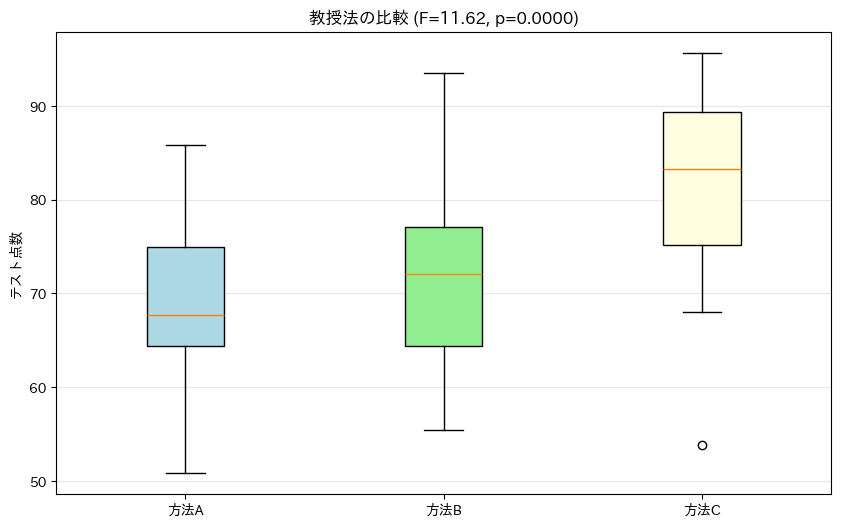

In [32]:
# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

data = [method_a, method_b, method_c]
labels = ['方法A', '方法B', '方法C']

bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('テスト点数')
ax.set_title(f'教授法の比較 (F={f_stat:.2f}, p={p_value:.4f})')
ax.grid(axis='y', alpha=0.3)
plt.show()

### 6.2 効果量（η²）

In [33]:
# 効果量の計算
all_data = np.concatenate([method_a, method_b, method_c])
grand_mean = all_data.mean()

# 群間変動
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in [method_a, method_b, method_c])

# 全変動
ss_total = sum((x - grand_mean)**2 for x in all_data)

# η²（イータ二乗）
eta_squared = ss_between / ss_total

print("=== 効果量 ===")
print(f"η² = {eta_squared:.4f}")
print(f"\n効果量の目安:")
print(f"  小: 0.01, 中: 0.06, 大: 0.14")
if eta_squared >= 0.14:
    print(f"  → 大きな効果")
elif eta_squared >= 0.06:
    print(f"  → 中程度の効果")
else:
    print(f"  → 小さな効果")

=== 効果量 ===
η² = 0.2439

効果量の目安:
  小: 0.01, 中: 0.06, 大: 0.14
  → 大きな効果


### 📝 6章 練習問題

1. 4つのグループのデータを生成し、一元配置分散分析を行いなさい。
2. 効果量η²を計算し、効果の大きさを評価しなさい。
3. ANOVAの前提条件（正規性、等分散性）を確認する方法を説明しなさい。

In [34]:
# 練習問題の解答欄



---
## 7. 信頼区間の計算

母数の推定における不確実性を表す信頼区間を学びます。

### 7.1 母平均の信頼区間

In [35]:
# サンプルデータ
np.random.seed(42)
data = stats.norm.rvs(loc=100, scale=15, size=50)

# 95%信頼区間
mean = data.mean()
sem = stats.sem(data)
ci = stats.t.interval(confidence=0.95, df=len(data)-1, loc=mean, scale=sem)

print("=== 母平均の95%信頼区間 ===")
print(f"標本平均: {mean:.2f}")
print(f"標準誤差: {sem:.2f}")
print(f"95%信頼区間: ({ci[0]:.2f}, {ci[1]:.2f})")
print(f"区間幅: {ci[1] - ci[0]:.2f}")

=== 母平均の95%信頼区間 ===
標本平均: 96.62
標準誤差: 1.98
95%信頼区間: (92.64, 100.60)
区間幅: 7.96


In [36]:
# 異なる信頼水準での信頼区間
print("=== 異なる信頼水準での信頼区間 ===")
for confidence in [0.90, 0.95, 0.99]:
    ci = stats.t.interval(confidence=confidence, df=len(data)-1, loc=mean, scale=sem)
    print(f"{confidence*100:.0f}%信頼区間: ({ci[0]:.2f}, {ci[1]:.2f})")

=== 異なる信頼水準での信頼区間 ===
90%信頼区間: (93.30, 99.94)
95%信頼区間: (92.64, 100.60)
99%信頼区間: (91.31, 101.93)


### 7.2 母比率の信頼区間

In [37]:
# 成功の数と試行数
successes = 45
n_trials = 100

# 二項分布による信頼区間
p_hat = successes / n_trials

# 正規近似による95%信頼区間
z = stats.norm.ppf(0.975)
se = np.sqrt(p_hat * (1 - p_hat) / n_trials)
ci_low = p_hat - z * se
ci_high = p_hat + z * se

print("=== 母比率の95%信頼区間 ===")
print(f"成功数: {successes}, 試行数: {n_trials}")
print(f"標本比率: {p_hat:.2f}")
print(f"95%信頼区間: ({ci_low:.3f}, {ci_high:.3f})")

=== 母比率の95%信頼区間 ===
成功数: 45, 試行数: 100
標本比率: 0.45
95%信頼区間: (0.352, 0.548)


### 7.3 サンプルサイズと信頼区間の関係

In [38]:
# サンプルサイズによる信頼区間の変化
np.random.seed(42)
population = stats.norm.rvs(loc=100, scale=15, size=10000)

sample_sizes = [10, 30, 100, 300]
results = []

for n in sample_sizes:
    sample = np.random.choice(population, size=n, replace=False)
    mean = sample.mean()
    sem = stats.sem(sample)
    ci = stats.t.interval(confidence=0.95, df=n-1, loc=mean, scale=sem)
    results.append((n, mean, ci[0], ci[1]))

print("=== サンプルサイズと信頼区間 ===")
print(f"{'n':>6} {'平均':>8} {'下限':>8} {'上限':>8} {'幅':>8}")
for n, m, low, high in results:
    print(f"{n:>6} {m:>8.2f} {low:>8.2f} {high:>8.2f} {high-low:>8.2f}")

=== サンプルサイズと信頼区間 ===
     n       平均       下限       上限        幅
    10    94.04    79.88   108.21    28.34
    30    98.41    93.17   103.66    10.49
   100   100.18    97.46   102.90     5.44
   300   101.11    99.43   102.80     3.37


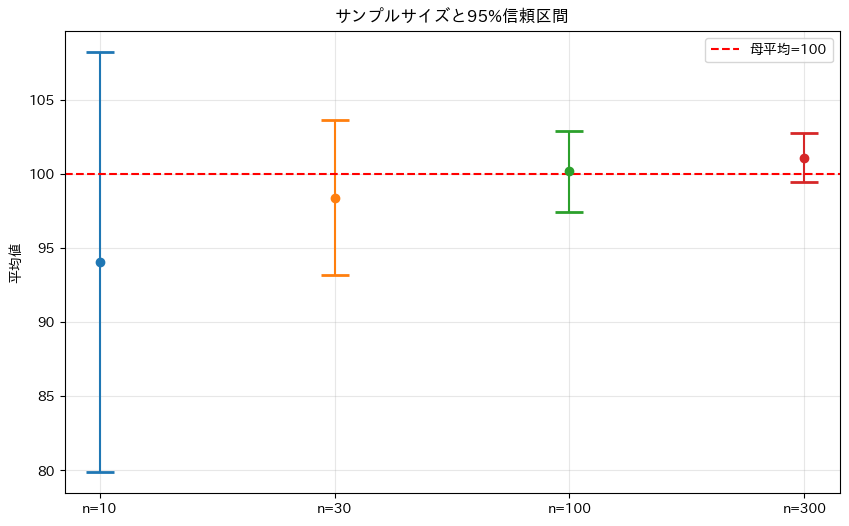

In [39]:
# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

for i, (n, m, low, high) in enumerate(results):
    ax.errorbar(i, m, yerr=[[m-low], [high-m]], fmt='o', capsize=10, capthick=2)

ax.axhline(y=100, color='r', linestyle='--', label='母平均=100')
ax.set_xticks(range(len(sample_sizes)))
ax.set_xticklabels([f'n={n}' for n in sample_sizes])
ax.set_ylabel('平均値')
ax.set_title('サンプルサイズと95%信頼区間')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### 📝 7章 練習問題

1. 30人のサンプルで95%信頼区間を計算し、99%信頼区間と比較しなさい。
2. 信頼区間の解釈を正しく説明しなさい（「95%の確率で母平均が含まれる」は正しいか？）。
3. 必要なサンプルサイズを信頼区間の幅から逆算する方法を考えなさい。

In [40]:
# 練習問題の解答欄



---
## 8. 多重比較補正

複数の検定を行う際のα水準の調整方法を学びます。

### 8.1 多重比較の問題

複数の検定を行うと、全体の第1種の過誤（誤って帰無仮説を棄却する）確率が増加します。

In [41]:
# 多重比較の問題のシミュレーション
np.random.seed(42)

n_tests = 20
alpha = 0.05

# 全て帰無仮説が真（差がない）場合
p_values = []
for _ in range(n_tests):
    # 同じ分布から2群サンプリング
    g1 = stats.norm.rvs(size=30)
    g2 = stats.norm.rvs(size=30)
    _, p = stats.ttest_ind(g1, g2)
    p_values.append(p)

significant_count = sum(p < alpha for p in p_values)

print("=== 多重比較の問題 ===")
print(f"検定回数: {n_tests}")
print(f"α水準: {alpha}")
print(f"有意となった検定数: {significant_count}")
print(f"\n帰無仮説が全て真でも、{n_tests}回中約{n_tests*alpha:.0f}回は")
print(f"偶然有意になることが期待される（Family-wise error）")

=== 多重比較の問題 ===
検定回数: 20
α水準: 0.05
有意となった検定数: 1

帰無仮説が全て真でも、20回中約1回は
偶然有意になることが期待される（Family-wise error）


### 8.2 ボンフェローニ補正

In [42]:
# ボンフェローニ補正
alpha_corrected = alpha / n_tests
significant_bonferroni = sum(p < alpha_corrected for p in p_values)

print("=== ボンフェローニ補正 ===")
print(f"補正前のα: {alpha}")
print(f"補正後のα: {alpha_corrected:.4f}")
print(f"補正前の有意な検定数: {significant_count}")
print(f"補正後の有意な検定数: {significant_bonferroni}")

=== ボンフェローニ補正 ===
補正前のα: 0.05
補正後のα: 0.0025
補正前の有意な検定数: 1
補正後の有意な検定数: 0


### 8.3 ホルム法（Holm-Bonferroni法）

In [43]:
# ホルム法による補正
from scipy.stats import false_discovery_control

# p値をソート
sorted_p = np.sort(p_values)
n = len(p_values)

print("=== ホルム法 ===")
print(f"{'順位':>4} {'p値':>8} {'補正α':>10} {'有意':>6}")
print("-" * 32)

for i, p in enumerate(sorted_p[:5]):  # 最初の5つだけ表示
    adjusted_alpha = alpha / (n - i)
    significant = 'Yes' if p < adjusted_alpha else 'No'
    print(f"{i+1:>4} {p:>8.4f} {adjusted_alpha:>10.4f} {significant:>6}")
print("...")

=== ホルム法 ===
  順位       p値        補正α     有意
--------------------------------
   1   0.0117     0.0025     No
   2   0.1059     0.0026     No
   3   0.1334     0.0028     No
   4   0.1477     0.0029     No
   5   0.1552     0.0031     No
...


### 8.4 FDR（偽発見率）の制御

In [44]:
# Benjamini-Hochberg法によるFDR制御
sorted_indices = np.argsort(p_values)
sorted_p = np.array(p_values)[sorted_indices]

# BH法の閾値
bh_thresholds = [(i + 1) * alpha / n for i in range(n)]

print("=== Benjamini-Hochberg法（FDR制御）===")
print(f"{'順位':>4} {'p値':>8} {'BH閾値':>10} {'有意':>6}")
print("-" * 32)

significant_bh = 0
for i, (p, th) in enumerate(zip(sorted_p, bh_thresholds)):
    if p <= th:
        significant_bh = i + 1

for i in range(5):
    p = sorted_p[i]
    th = bh_thresholds[i]
    sig = 'Yes' if i < significant_bh else 'No'
    print(f"{i+1:>4} {p:>8.4f} {th:>10.4f} {sig:>6}")
print("...")
print(f"\nBH法で有意な検定数: {significant_bh}")

=== Benjamini-Hochberg法（FDR制御）===
  順位       p値       BH閾値     有意
--------------------------------
   1   0.0117     0.0025     No
   2   0.1059     0.0050     No
   3   0.1334     0.0075     No
   4   0.1477     0.0100     No
   5   0.1552     0.0125     No
...

BH法で有意な検定数: 0


### 8.5 補正方法の比較

In [45]:
print("=== 多重比較補正の比較 ===")
print(f"\n検定回数: {n_tests}")
print(f"元のα: {alpha}")
print(f"\n補正なし: {significant_count} 件有意")
print(f"ボンフェローニ補正: {significant_bonferroni} 件有意")
print(f"BH法（FDR）: {significant_bh} 件有意")
print(f"\n※ ボンフェローニは保守的（第2種の過誤が増加）")
print(f"※ BH法はより検出力が高いが、一部の偽陽性を許容")

=== 多重比較補正の比較 ===

検定回数: 20
元のα: 0.05

補正なし: 1 件有意
ボンフェローニ補正: 0 件有意
BH法（FDR）: 0 件有意

※ ボンフェローニは保守的（第2種の過誤が増加）
※ BH法はより検出力が高いが、一部の偽陽性を許容


### 📝 8章 練習問題

1. 100回の検定を行い、ボンフェローニ補正とBH法を適用して結果を比較しなさい。
2. Family-wise error rateとFalse discovery rateの違いを説明しなさい。
3. どのような研究分野でどの補正方法が適切か考察しなさい。

In [46]:
# 練習問題の解答欄



---
## まとめ

このチュートリアルで学んだことをまとめます：

| 検定の種類 | 関数 | 用途 |
|-----------|------|------|
| 1標本t検定 | `stats.ttest_1samp()` | 標本平均と母平均の比較 |
| 対応のあるt検定 | `stats.ttest_rel()` | 同一被験者の前後比較 |
| 独立2標本t検定 | `stats.ttest_ind()` | 2群の平均比較 |
| ルビーン検定 | `stats.levene()` | 等分散性の検定 |
| カイ二乗適合度検定 | `stats.chisquare()` | 観測度数と期待度数の比較 |
| カイ二乗独立性検定 | `stats.chi2_contingency()` | 2変数の独立性 |
| ピアソン相関 | `stats.pearsonr()` | 線形相関 |
| スピアマン相関 | `stats.spearmanr()` | 順位相関 |
| マン・ホイットニー検定 | `stats.mannwhitneyu()` | 2群比較（ノンパラメトリック）|
| 一元配置分散分析 | `stats.f_oneway()` | 3群以上の平均比較 |

## 重要なポイント

1. **検定の前提条件を確認**: 正規性、等分散性など
2. **効果量も報告**: p値だけでなく効果の大きさも重要
3. **多重比較の補正**: 複数検定時はα水準を調整
4. **適切な検定を選択**: パラメトリック vs ノンパラメトリック

---
## 総合演習

これまで学んだ内容を使って、以下の課題に挑戦してください。

### 課題：実験データの統計分析

新しい学習法の効果を検証する実験を想定します。

1. **データ生成**: 3つの学習法（従来法、新法A、新法B）で学習した生徒のテスト点数を生成
   - 各群30人
   - 従来法: 平均65、標準偏差12
   - 新法A: 平均70、標準偏差10
   - 新法B: 平均72、標準偏差11

2. **前提条件の確認**:
   - 各群の正規性を検定
   - 等分散性を検定

3. **主分析**:
   - 一元配置分散分析を実行
   - 効果量を計算

4. **事後比較**:
   - 全ての組み合わせでt検定を実行
   - 多重比較補正を適用

5. **結果の報告**:
   - 結果を箱ひげ図で可視化
   - 結論をまとめる

In [47]:
# 総合演習の解答欄

